# Taller 3

### Juan Daniel Torres Amézquita (201414896)

In [55]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import string
import matplotlib.cm as cm
import os
from scipy import ndimage

Populating the interactive namespace from numpy and matplotlib


## Punto 1

A continuación se encuentra la función para leer e importar los datos de VBOX.

In [56]:
def importarDatos (directorio, archivo):

    base_dir = directorio
    data_file = archivo
    with open(os.path.join(base_dir,data_file), 'r', encoding='cp1252') as vboxdata:
        section = []
        time = []
        lat = []
        long = []
        vel = []
        height = []
        vertv = []
        for line in vboxdata:
            if line[0] == '[':
                section = str.replace(line, "\n","")
                continue
            if section == '[column names]':
                col_names = str.replace(line, "  \n","").split('  ')
                section = []
            if section == '[data]':
                linesplit = str.replace(line, " \n","").split(' ')
                time.append(float(linesplit[1][0:2])*3600+float(linesplit[1][2:4])*60+float(linesplit[1][4:]))
                lat.append(float(linesplit[2]))
                long.append(float(linesplit[3]))
                vel.append(float(linesplit[4]))
                height.append(float(linesplit[6]))
                vertv.append(float(linesplit[7]))

    time = np.asarray(time)
    lat = np.asarray(lat)
    long = np.asarray(long)
    vel = np.asarray(vel)
    height = np.asarray(height)
    vertv = np.asarray(vertv)
    time_base = time[0]
    time = time - time_base
    lat = lat/60.0
    long = -long/60.0
    dt = time[1]-time[0]
    arraytot = [time,lat,long,vel,height,vertv,dt]
    return arraytot

In [57]:
datos_elec = importarDatos('data_electrico','VBS__047.VBO')
datos_comb = importarDatos('data_cordoba','VBOX0019.VBO')

## Punto 2 

A continuación, comparamos los tiempos, velocidades y aceleraciones en una vuelta.

Primero, importamos los datos y funciones de cada kart. Segundo, definimos una función para leer los datos del VBOX y establecer en qué momento cada vehículo da una vuelta. Finalmente, definimos una función que permita graficar las velocidades y aceleraciones en términos del tiempo.

Se introducen las funciones del kart de combustión.

In [58]:
# Datos kart combustión
# Datos Llantas tractivas 
rll=0.139 # Radio geométrico de las llantas en traseras (m)
refc=0.98*rll # Radio efectivo llantas traseras (m)
rin=0.0631 #radio interno del neumático (m)

# Datos Transmisión
dp=11.0 # Dientes del piñon
dpl=87.0 # Dientes del plato
ng=dpl/dp # Relación de Transmisión
etaf=0.95 # Eficiencia de transmisión

# Datos eje llantas
reje=0.02 # Radio eje de las llantas (m)
meje=3.832 # Masa del eje (kg)

# Datos Kart general
masa_comb=140.0 # masa del Kart con piloto(kg)
g=9.81 # Gravedad (m/s)
w_comb=masa_comb*g # peso del Kart (N)

# Datos Fuerzas de la fórmula de aceleración
rho=1.1955 # densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
vw=0.0 # velocidad del viento (m/s)
theta=0.0 # Angulo carretera

# Inercias
ii=0.01 # Inercia motor de combustión 

mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)
mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)

rpi=0.01525 # Radio Piñon (m)
rpla=0.10775 # Radio Plato (m)
rhoac=7850.0 # Densidad del Acero (kg/m^3)
bpi=0.01 # Ancho piñon (m)
bpla=0.01 # Ancho plato (m)
vpi= bpi*np.pi*rpi**2 # Volumen del piñon (m^3)
vpla=bpla*np.pi*rpla**2 # Volumen del plato (m^3)
mpi=rhoac*vpi # Masa del piñon (kg)
mpla=rhoac*vpla # Masa del plato (kg)
ig=((mpi*(rpi**2))/2)+((mpla*(rpla**2))/2) # Inercia de la transmisión (kg-m^2)

ieje=(meje*reje**2)/2 # Inercia del eje de las llantas (kg-m^2)

# Fuerzas Aceleración
# Resistencia a la rodadura
a=0.2036 # Distancia del centro de gravedad al eje de la llanta trasera (m)
l=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
h=0.0960 # Altura del centro de gravedad del kart con respecto al piso (m)

def accel(vx, ddt, sigma):
    return ndimage.gaussian_filter1d(vx, sigma=20, order=1, mode='wrap') / ddt

def frodadura(vx,ax):
    wr=w*((a/l)+(ax/g*(h/l))) # fuerza vertical sobre las llantas tractivas
    fr=0.01*(1+(vx/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)
    return wr*fr # (N)

# Fuerza del ángulo de la carretera
def finclinacion(theta):
    return w*sin(theta) # (N)

# Fuerza de arrastre
def farrastre(vx):
    return (1/2.0)*rho*af*cd*(vx+vw)**2 # (N)

# Fuerza de tracción, Torque del Motor
def ftraccion(ax,Fg,Fw,Fr):
    return masa*ax+Fg+Fw+Fr

def torquemotor(ax,Ft):
    return (Ft+(((ii-ig)/(ng**2))+ieje+illd*2+illt*2)*(ax/(refc**2)))*(refc/(ng*etaf)) # Torque del motor (Nm)

# Velocidad angular del motor
def vangularmotor(vx):
    return (vx*ng)/refc # (rad/s)

Se introducen las funciones y características del kart eléctrico.

In [59]:
# Datos kart eléctrico
# Datos Llantas tractivas 
rll=0.139 # Radio geométrico de las llantas en traseras (m)
r=0.98*rll # Radio efectivo llantas traseras (m)
rin=0.0631 #radio interno del neumático (m)

dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
rho=1.1955 # densidad del aire (kg/m^3)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
vw=0.0 # velocidad del viento (m/s)
theta=0.0 # Angulo carretera
g=9.81 # Gravedad (m/s)

## Datos Transmisión
dp=1 # Dientes del piñon
dpl=3.54 # Dientes del plato
Nc=dpl/dp # Relación de Transmisión
ef=0.95 # Eficiencia de transmisión

# Datos eje llantas
reje=0.02 # Radio eje de las llantas (m)
meje=3.832 # Masa del eje (kg)

# Datos Kart general
masa=152 # masa del Kart (kg)
g=9.81 # Gravedad (m/s)
w=masa*g # peso del Kart (N)
m = masa

# Datos Inercias
i_e=5.2E-3 # Inercia motor de combustión (kg m^2) 

rpi=0.01525#(m)
rpla=0.04096 #(m)
rhoac=7850.0 # Densidad del Acero (kg/m^3)
bpi=0.01 # Ancho piñon (m)
bpla=0.02 # Ancho plato (m)
vpi= bpi*np.pi*rpi**2 # Volumen del piñon (m^3)
vpla=bpla*np.pi*rpla**2 # Volumen del plato (m^3)
mpi=rhoac*vpi # Masa del piñon (kg)
mpla=rhoac*vpla # Masa del plato (kg)
mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)
mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)
ig=((mpi*(rpi**2))/2.0)+((mpla*(rpla**2))/2.0) # Inercia de la transmisión (kg-m^2)
ieje=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)
i_w = 2*illd + 2*illt
i_d = ig + ieje


def t_engine(vx,Nc):
    omega_llanta = (vx/r)
    omega_motor = omega_llanta*Nc
    rpm = omega_motor*30/(np.pi)
    P =((-0.00000004564538677*rpm**3)+(0.0001056995459*rpm**2)+(1.53209191*rpm)-1.895523696)
    T = P/omega_motor
    return T

def power_elec(vx,Nc):
    omega_llanta = (vx/r)
    omega_motor = omega_llanta*Nc
    rpm = omega_motor*30/(np.pi)
    P =((-0.00000004564538677*rpm**3)+(0.0001056995459*rpm**2)+(1.53209191*rpm)-1.895523696)
    return P

A continuación se define la función que dibuja las vueltas de cada kart, según los datos de latitud y longitud. Posteriormente, obtenemos los tiempos de cada vuelta.

In [60]:
def mapa (longitud, latitud, inicio, puntos):
    plot(latitud[inicio:inicio+puntos],longitud[inicio:inicio+puntos])
    figura = pylab.savefig('mapa.png')
    return figura

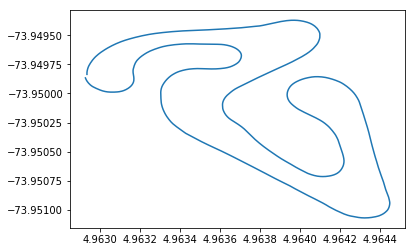

In [61]:
mapa(datos_comb[2],datos_comb[1],15690,5560) #Graficamos una vuelta del kart de combustión

In [62]:
tiempoVueltaComb = (datos_comb[0][15690+5560])-(datos_comb[0][15690]) # Obtenemos el tiempo de vuelta del kart de combustión.
tiempoVueltaComb

55.600000000005821

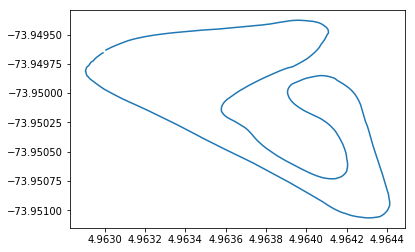

In [63]:
mapa(datos_elec[2],datos_elec[1],350,1200) # Graficamos una vuelta del kart eléctrico.

In [64]:
tiempoVueltaElec = (datos_elec[0][350+1200])-(datos_elec[0][350]) # Obtenemos el tiempo de vuelta del kart eléctrico.
tiempoVueltaElec

60.0

A continuación, definimos la función para graficar aceleraciones y velocidades a lo largo del tiempo en cada una de las vueltas.

In [65]:
def graf2Comp(tiempo1, velocidad1, dt1, tiempo2, velocidad2, dt2):
    inicio_comb = 15690
    puntos_comb = 5560
    inicio_elec = 350
    puntos_elec = 1200
    
    tiempo1final = tiempo1[inicio_comb+puntos_comb]-tiempo1[inicio_comb]
    tiempo1inicial = 0
    sp1 = len(velocidad1[inicio_comb:inicio_comb+puntos_comb])
    t1 = linspace(tiempo1inicial, tiempo1final, sp1)
    
    tiempo2final = tiempo2[inicio_elec+puntos_elec]-tiempo1[inicio_elec]
    tiempo2inicial = 0
    sp2 = len(velocidad2[inicio_elec:inicio_elec+puntos_elec])
    t2 = linspace(tiempo2inicial, tiempo2final, sp2)
    
    vel1master = velocidad1/3.6
    vel2master = velocidad2/3.6
    
    aceleracion1 = accel(vel1master[inicio_comb:inicio_comb+puntos_comb],dt1,20)
    aceleracion2 = accel(vel2master[inicio_elec:inicio_elec+puntos_elec],dt2,0)
    
    figure(figsize=(12,4))
    plt.subplot(1,1,1)
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Velocidad [km/h]')
    plt.title('Velocidad vs Tiempo')
    plt.plot(t1,velocidad1[inicio_comb:inicio_comb+puntos_comb], '-r', label= 'Velocidad combustión')
    plt.plot(t2,velocidad2[inicio_elec:inicio_elec+puntos_elec], '-b', label= 'Velocidad eléctrico')
    plt.grid()
    plt.legend(loc='best')
    plt.show()

    figure(figsize=(12,4))
    plt.subplot(1,1,1)
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Aceleración [m^2/s]')
    plt.title('Aceleración vs Tiempo')
    plt.plot(t1,aceleracion1, '-r', label= 'Aceleración combustión')
    plt.plot(t2,aceleracion2, '-b', label= 'Aceleración eléctrico')
    plt.grid()
    plt.legend(loc='best')
    plt.show()

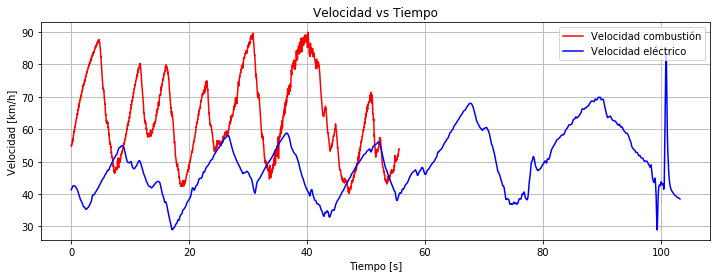

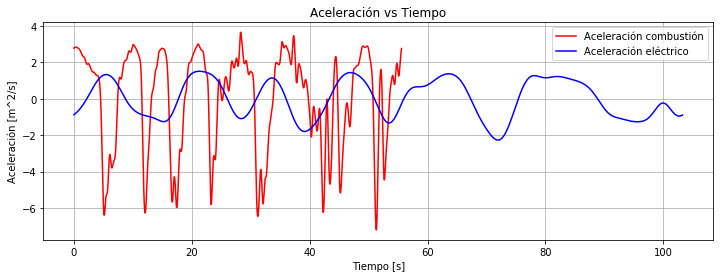

In [66]:
graf2Comp(datos_comb[0], datos_comb[3],datos_comb[6],datos_elec[0],datos_elec[3],datos_elec[6]) # Se grafican las velocidades y aceleraciones con respecto al tiempo.

## Punto 3

A continuación procedemos a realizar las gráficas del torque, la potencia y la velocidad angular para cada motor.

In [67]:
def graf3Comp(tiempo1, velocidad1, dt1, tiempo2, velocidad2, dt2):
    inicio_comb = 15690
    puntos_comb = 5560
    inicio_elec = 350
    puntos_elec = 1200
    
    tiempo1final = tiempo1[inicio_comb+puntos_comb]-tiempo1[inicio_comb]
    tiempo1inicial = 0
    sp1 = len(velocidad1[inicio_comb:inicio_comb+puntos_comb])
    t1 = linspace(tiempo1inicial, tiempo1final, sp1)
    
    tiempo2final = tiempo2[inicio_elec+puntos_elec]-tiempo1[inicio_elec]
    tiempo2inicial = 0
    sp2 = len(velocidad2[inicio_elec:inicio_elec+puntos_elec])
    t2 = linspace(tiempo2inicial, tiempo2final, sp2)
    
    # Combustión
    vel1master = velocidad1/3.6
    aceleracion1 = accel(vel1master[inicio_comb:inicio_comb+puntos_comb],dt1,20)
    f_inc1 = finclinacion(theta)
    f_arr1 = farrastre(vel1master[inicio_comb:inicio_comb+puntos_comb])
    f_rod1 = frodadura(velocidad1[inicio_comb:inicio_comb+puntos_comb],aceleracion1)
    f_trac1 = ftraccion(aceleracion1,f_inc1,f_arr1,f_rod1)
    torq1 = torquemotor(aceleracion1,f_trac1)
    omega_eng1 = vangularmotor(vel1master[inicio_comb:inicio_comb+puntos_comb])
    pot_1 = (omega_eng1*torq1)/1000
   
    # Eléctrico
    vel2master = velocidad2/3.6
    aceleracion2 = accel(vel2master[inicio_elec:inicio_elec+puntos_elec],dt2,0)
    f_inc2 = finclinacion(theta)
    f_arr2 = farrastre(vel2master[inicio_elec:inicio_elec+puntos_elec])
    f_rod2 = frodadura(velocidad2[inicio_elec:inicio_elec+puntos_elec],aceleracion2)
    f_trac2 = ftraccion(aceleracion2,f_inc2,f_arr2,f_rod2)
    torq2 = torquemotor(aceleracion2,f_trac2)
    omega_eng2 = vangularmotor(vel2master[inicio_elec:inicio_elec+puntos_elec])
    pot_2 = (omega_eng2*torq2)/1000
    #torq2 = t_engine(vel2master[inicio_elec:inicio_elec+puntos_elec],Nc)
    #omega_eng2 = vangularmotor(vel2master[inicio_elec:inicio_elec+puntos_elec])
    #pot_2 = power_elec(vel2master[inicio_elec:inicio_elec+puntos_elec],Nc)
    
    figure(figsize=(12,4))
    plt.subplot(1,1,1)
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Torque [N*m]')
    plt.title('Torque vs Tiempo')
    plt.plot(t1,torq1,'-r', label= 'Torque combustión')
    plt.plot(t2,torq2,'-b', label= 'Torque eléctrico')
    plt.grid()
    plt.legend(loc='best')
    plt.show()
    
    figure(figsize=(12,4))
    plt.subplot(1,1,1)
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Potencia [kW]')
    plt.title('Potencia vs Tiempo')
    plt.plot(t1,pot_1,'-r', label= 'Potencia combustión')
    plt.plot(t2,pot_2,'-b', label= 'Potencia eléctrico')
    plt.grid()
    plt.legend(loc='best')
    plt.show()
    
    figure(figsize=(12,4))
    plt.subplot(1,1,1)
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Velocidad angular [rpm]')
    plt.title('Velocidad angular vs Tiempo')
    plt.plot(t1,omega_eng1*30/np.pi, '-r', label= 'Velocidad angular combustión')
    plt.plot(t2,omega_eng2*30/np.pi, '-b', label= 'Velocidad angular eléctrico')
    plt.grid()
    plt.legend(loc='best')
    plt.show()

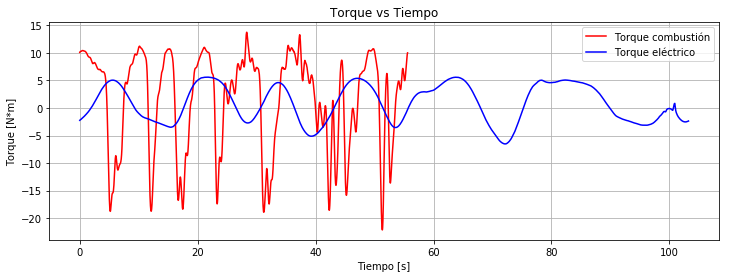

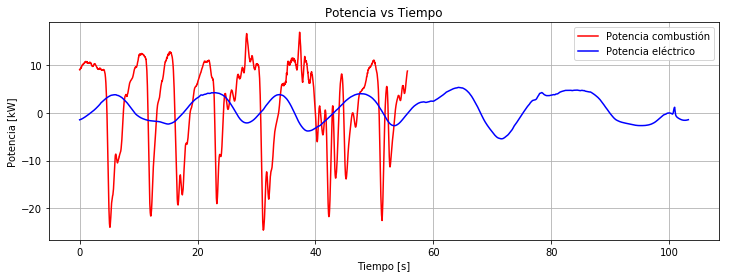

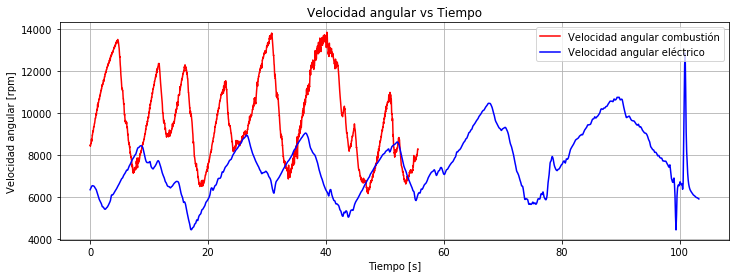

In [68]:
graf3Comp(datos_comb[0], datos_comb[3],datos_comb[6],datos_elec[0],datos_elec[3],datos_elec[6]) # Se hacen las gráficas de torque, potencia y velocidad angular con respecto al tiempo.

## Punto 4 (análisis de resultados)

#### Vueltas y tiempo de vueltas

- Podemos observar en los mapas de vueltas que mientras que el piloto del kart de combustión da una vuelta por toda la longitud del circuito, el piloto del kart eléctrico toma un atajo, lo cual acorta la vuelta. Esto es claramente visible en las figuras que describen el movimiento del kart en términos de longitud y latitud.
- Los tiempos de vuelta para kart de combustión y kart eléctrico son 55.6 y 60 segundos respectivamente.
- Esto nos da un primer indicio de que el kart de combustión tiene un mejor desempeño en pista que el kart eléctrico, ya que incluso recorriendo más distancia que el kart eléctrico se demora menos en dar la vuelta.

#### Gráficas de velocidad y aceleración

- Las velocidades alcanzadas por el kart eléctrico son menores que en el kart de combustión. Por ejemplo, la velocidad máxima alcanzada por el kart de combustión es de aproximadamente 90km/h, mientras que en el kart eléctrico es de alrededor de 70km/h.

- Las aceleraciones son de mayor magnitud en el kart de combustión que en el eléctrico. Esto nos indica a que hay una diferencia fundamental en la forma en cómo opera el motor con el kart, ya que la diferencia de pesos entre los karts es relativamente pequeña.

- Al final del recorrido del kart eléctrico hay una divergencia fuerte de los datos de velocidad, lo cual puede evidenciar un error con los datos medidos del GPS.

#### Gráficas de torque, potencia y velocidad angular

En todos los casos, las prestaciones dadas por el motor eléctrico son inferiores a aquellas dadas por el motor de combustión.
- Los torques del motor de combustión superan los 10Nm, mientras que el motor eléctrico entrega torques de aproximadamente 5Nm, casi la mitad.
- Consecuencia de esto, también se afectan las potencias entregadas por cada motor. El motor de combustión entrega potencia en excesos de 10kW, mientras que la potencia máxima entregada por el motor eléctrico no pasa de los 4kW.
- Finalmente, se encuentra una gráfica de las velocidades angulares de cada motor en su operación. El motor de combustión logra velocidades angulares máximas de 14000RPM, mientras que el motor eléctrico llega a aproximadamente 11000RPM.

#### Conclusiones

En el análisis de resultados vimos evidenciado que el motor de combustión tiene un mejor rendimiento y prestaciones en todos los casos. El motor de combustión ofrece:
- Mayor torque
- Mayor potencia 
- Mayor velocidad angular

Visto desde esta perspectiva, el rendimiento del motor eléctrico simplemente no se puede comparar con el del motor de combustión, ya que el rendimiento total del vehículo depende en gran parte de estas tres variables. Una solución posible es alimentar el motor con una frecuencia de entrada mayor a la que se tiene actualmente con el objetivo de alcanzar velocidades angulares mayores. Posteriormente, se debería usar una relación mayor (más parecida a la que tiene el kart de combustión) con el fin de que se pueda aprovechar esta velocidad angular extra en velocidad lineal mayor. Adicionalmente, puede que el montaje del motor eléctrico tenga una ventaja de peso con respecto al motor de combustión, entonces se puede experimentar con pilotos más ligeros y chasis de menor peso para hacer énfasis en la ventaja del peso. Otra opción es cambiar el motor por uno de mejores prestaciones, no obstante, esto puede aumentar el peso del kart, por lo cual se perdería la ventaja de peso reducido.